In [1]:
import os
import grid2op
import datetime
import numpy as np
import pandas as pd
from copy import deepcopy
from grid2op.Agent import BaseAgent
from IPython import display  # for proper display in jupyter notebook
import matplotlib.pyplot as plt  # pip install matplotlib
from grid2op.Episode import EpisodeReplay
from grid2op.PlotGrid import PlotMatplot
import glob
from IPython.display import Image
from IPython.core.display import display, HTML

C:\Users\Kun\AppData\Local\Temp\ipykernel_2420\1940275471.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
DATA_PATH = './training_data_track1'  # for demo only, use your own dataset
SCENARIO_PATH = './training_data_track1/chronics'

In [3]:
try:
    from lightsim2grid import LightSimBackend
    backend = LightSimBackend()
    env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH, backend=backend)
except:
    env = grid2op.make(dataset=DATA_PATH, chronics_path=SCENARIO_PATH)

C:\Users\Kun\miniconda3\envs\py38rwth\lib\site-packages\lightsim2grid\lightSimBackend.py:45: UserWarning: Please use grid2op >= 1.7.1: with older grid2op versions, you cannot set max_iter, tol nor solver_type arguments.
  warnings.warn("Please use grid2op >= 1.7.1: with older grid2op versions, "
C:\Users\Kun\miniconda3\envs\py38rwth\lib\site-packages\lightsim2grid\gridmodel\_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
C:\Users\Kun\miniconda3\envs\py38rwth\lib\site-packages\lightsim2grid\gridmodel\_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


# Main Agent

In [4]:
class MyAgent(BaseAgent):
    def __init__(self, action_space, this_directory_path='./ActionSpace'): # customized
        ''' Initailize agent'''
        BaseAgent.__init__(self, action_space=action_space)
        '''actions import '''
        self.actions_ordinary = np.load(os.path.join(this_directory_path, 'actions177.npy')) #customized


        '''details chosen from observation'''
        # p: the active power produced at this node (MW)
        # q: the reactive power produced at this node (MVar)
        # v: the voltage magnitude at this node  (kV)
        # cooldown: how much longer you need to wait before being able to merge / split or change this node
        
       
        self.last_step = datetime.datetime.now()
        self.recovery_stack = []
        self.overflow_steps = 0

    def find_best_line_to_reconnect(self, obs, original_action):
        disconnected_lines = np.where(obs.line_status == False)[0] # given disconnected line array
        if not len(disconnected_lines): # the number of disconnected lines
            return original_action
        if (obs.time_before_cooldown_line[disconnected_lines] > 0).all():
            return original_action
        o, _, _, _ = obs.simulate(original_action)
        min_rho = o.rho.max()
        line_to_reconnect = -1
        for line in disconnected_lines:
            if not obs.time_before_cooldown_line[line]:
                reconnect_array = np.zeros_like(obs.rho, dtype = int)
                reconnect_array[line] = 1
                reconnect_action = deepcopy(original_action)
                reconnect_action.update({'set_line_status': reconnect_array})
                if not self.is_legal(reconnect_action, obs):
                    continue
                o, _, _, _ = obs.simulate(reconnect_action)
                if o.rho.max() < min_rho:
                    line_to_reconnect = line
                    min_rho = o.rho.max()
        if line_to_reconnect != -1:
            reconnect_array = np.zeros_like(obs.rho, dtype = int)
            reconnect_array[line_to_reconnect] = 1
            original_action.update({'set_line_status': reconnect_array})
        return original_action

    def array2action(self, array):
        action = self.action_space({'change_bus': array[236:413]})
        action._change_bus_vect = action._change_bus_vect.astype(bool)
        return action

    def is_legal(self, action, obs):
        adict = action.as_dict()
        if 'change_bus_vect' not in adict:
            return True
        substation_to_operate = int(adict['change_bus_vect']['modif_subs_id'][0])
        if obs.time_before_cooldown_sub[substation_to_operate]:
            return False
        
        for line in [eval(key) for key, val in adict['change_bus_vect'][str(substation_to_operate)].items()
                     if 'line' in val['type']]:
            if obs.time_before_cooldown_line[line] or not obs.line_status[line]:
                return False
        return True

    def act(self, observation, reward, done):
        
        tnow = observation.get_time_stamp()

        if self.last_step + datetime.timedelta(minutes=5) != tnow:
            print('\n\nscenario changes！')
            self.recovery_stack = []
        
        self.last_step = tnow

#         if observation.rho.max() >= 1:
#             self.overflow_steps += 1
#         else:
#             self.overflow_steps = 0

        # case: secure
        threshold_this_step = 0.999
        if observation.rho.max() < threshold_this_step:  # fixed threshold
            if (self.recovery_stack == []) or (not self.is_legal(self.array2action(self.actions_ordinary[self.recovery_stack[0]]), observation)):
                a = self.action_space({})
            else:
                o, r, d, i = observation.simulate(self.array2action(self.actions_ordinary[self.recovery_stack[0]]))
                if (not d) and (o.rho.max() < 0.98):
                    aid = self.recovery_stack.pop(0)
                    a = self.array2action(self.actions_ordinary[aid])
                else:
                    a = self.action_space({})
            return self.find_best_line_to_reconnect(observation, a)
    
    
        # case: dangerous
        o, _, d, _ = observation.simulate(self.action_space({}))
        min_rho = o.rho.max() if not d else 10
        print('%s, heavy load, line-%d load is %.2f' % 
              (str(observation.get_time_stamp()), observation.rho.argmax(), observation.rho.max()))

        action_chosen = None
        id_second_search = None
        min_rho0 = min_rho
        for idx, action_array in enumerate(self.actions_ordinary):
            a = self.array2action(action_array)
            if not self.is_legal(a, observation):
                continue
            obs, _, done, _ = observation.simulate(a)
            if done:
                continue
            if obs.rho.max() < min(min_rho, min_rho0 - 0.03):
                min_rho = obs.rho.max()
                action_chosen = a
                id_second_search = idx
        if id_second_search:
            self.recovery_stack.append(id_second_search)


        return  self.find_best_line_to_reconnect(observation, action_chosen) if action_chosen else self.find_best_line_to_reconnect(observation, self.action_space({}))

In [5]:
max_iter = 100 #customize
from grid2op.Runner import Runner
# from grid2op.Agent import DoNothingAgent
from grid2op.Reward import L2RPNReward
from grid2op.Chronics import GridStateFromFileWithForecasts

path_saved_data = './Res'
if not os.path.exists(path_saved_data):
    os.mkdir(path_saved_data)


runner = Runner(**env.get_params_for_runner(),
                agentClass=MyAgent)
res = runner.run(nb_episode=3, max_iter=max_iter, path_save=path_saved_data)
print("The results for the custom agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)
    




scenario changes！


scenario changes！


scenario changes！
2012-08-06 06:45:00, heavy load, line-41 load is 1.13
2012-08-06 06:50:00, heavy load, line-41 load is 1.12
2012-08-06 06:55:00, heavy load, line-41 load is 1.12
2012-08-06 07:00:00, heavy load, line-40 load is 1.11
2012-08-06 07:05:00, heavy load, line-40 load is 1.12
2012-08-06 07:10:00, heavy load, line-40 load is 1.12
2012-08-06 07:15:00, heavy load, line-34 load is 1.29
2012-08-06 07:20:00, heavy load, line-34 load is 1.28
2012-08-06 07:25:00, heavy load, line-34 load is 1.26
The results for the custom agent are:
	For chronics with id Scenario_august_dummly
		 - cumulative reward: 105158.664062
		 - number of time steps completed: 100 / 100
	For chronics with id Scenario_february_dummy
		 - cumulative reward: 85034.539062
		 - number of time steps completed: 100 / 100
	For chronics with id Scenario_august_dummly
		 - cumulative reward: 95944.234375
		 - number of time steps completed: 90 / 100


In [ ]:
'''output files'''
#plot_epi = EpisodeReplay(path_saved_data)
#plot_epi.replay_episode(res[0][1], gif_name="this_episode") # customize, check how many scenarios

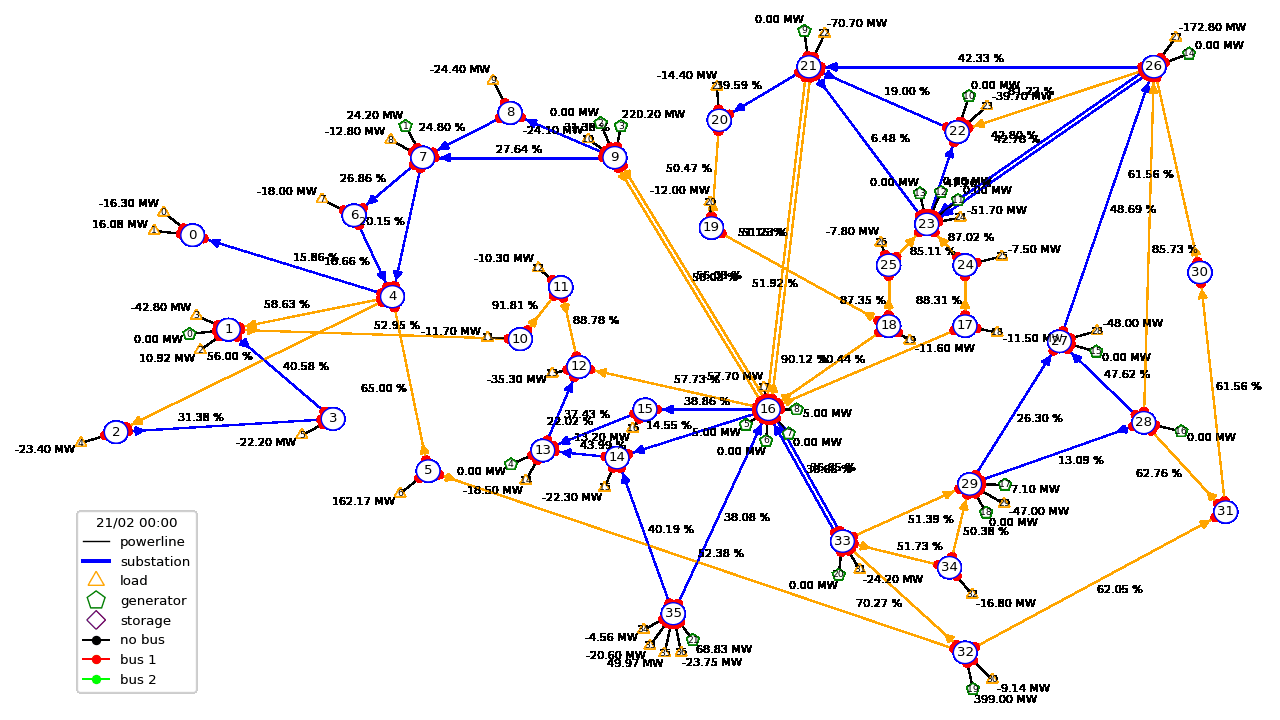

In [6]:
gif_path = './Res/Scenario_february_dummy/*.gif'

my_gif = glob.glob(gif_path)
img = None
if len(my_gif):
    my_gif = my_gif[0]
    img = Image(filename=my_gif)
    display(img)
else:
    print("No gif were generated, your agent probably fails before.")